# Imports

In [1]:
import os
import sys
import re
import pickle
import random
import collections
from enum import (
    Enum,
    unique
)
from typing import (
    Dict,
    List,
    Optional
)

import numpy as np
from numpy import ndarray

import pandas as pd
from pandas import DataFrame

from matplotlib import pyplot as plt

In [2]:
# Place the package on the path

QSRR_PATH: str = os.path.join(os.path.dirname(os.getcwd()))

if QSRR_PATH not in sys.path:
    sys.path.insert(0, QSRR_PATH)

In [3]:
from qsrr.enums import MoleculeEncodingType
from qsrr.process import (
    MoleculeEncoder,
    MoleculeParser
)

# Load and Process Data

In [4]:
DATA_PATH: str = os.path.join(QSRR_PATH, "data")
SMRT_DATASET: str = os.path.join(DATA_PATH, "2023-11-18-smrt_dataset.csv")
SMRT_DATASET_SMILES: str = os.path.join(DATA_PATH, "2023-11-18-smrt_dataset_smiles.csv")
SMRT_DATASET_ENCODED_SMILES: str = os.path.join(DATA_PATH, "2023-11-18-smrt_dataset_encoded_smiles.pkl")

In [5]:
_data_df = pd.read_csv(
    SMRT_DATASET, 
    delimiter=';'
)

In [6]:
display(_data_df.head())

,pubchem,rt,inchi
0,5139,93.5,"InChI=1S/C3H8N2S/c1-2-6-3(4)5/h2H2,1H3,(H3,4,5)"
1,3505,687.8,InChI=1S/C19H25Cl2N3O3/c1-27-19(26)23-8-9-24(1...
2,2159,590.7,InChI=1S/C17H27N3O4S/c1-4-20-8-6-7-12(20)11-19...
3,1340,583.6,InChI=1S/C9H7NO2/c11-8-3-1-2-7-6(8)4-5-10-9(7)...
4,3344,579.0,InChI=1S/C15H20N2O2/c18-14-16-12-15(19-14)7-10...


In [7]:
_data_df['rt'].describe().round(2)

count    80038.00
mean       790.22
std        206.68
min          0.30
25%        661.00
50%        773.50
75%        912.50
max       1471.70
Name: rt, dtype: float64

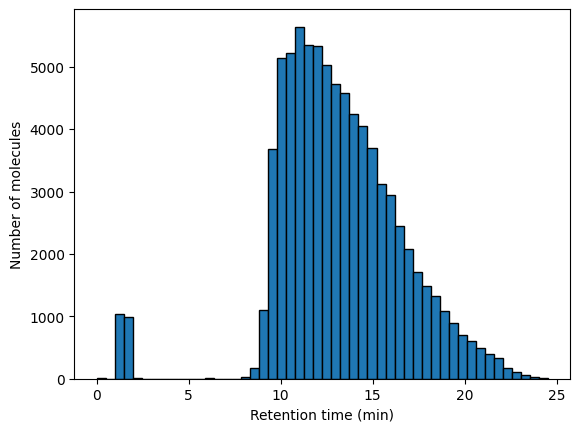

In [8]:
# Plot the distribution of the retention times
plt.hist(
    _data_df['rt'] / 60, 
    bins=50, 
    edgecolor='black'
)
plt.xlabel('Retention time (min)')
plt.ylabel('Number of molecules')
plt.show()

In [9]:
# Filter out data with RT < 7 minutes
_threshold_rt = 7 * 60
_data_adjusted_df = _data_df.loc[_data_df['rt'] > _threshold_rt].reset_index(drop=True)
_count = _data_df[_data_df['rt'] < _threshold_rt].count()

In [10]:
print(f'Number of rows with rt values less than {_threshold_rt // 60} minutes: ', _count.iloc[0])

Number of rows with rt values less than 7 minutes:  2063


In [11]:
display(_data_adjusted_df['rt'].describe().round(2))

count    77975.00
mean       808.75
std        174.67
min        431.70
25%        669.00
50%        779.90
75%        917.20
max       1471.70
Name: rt, dtype: float64

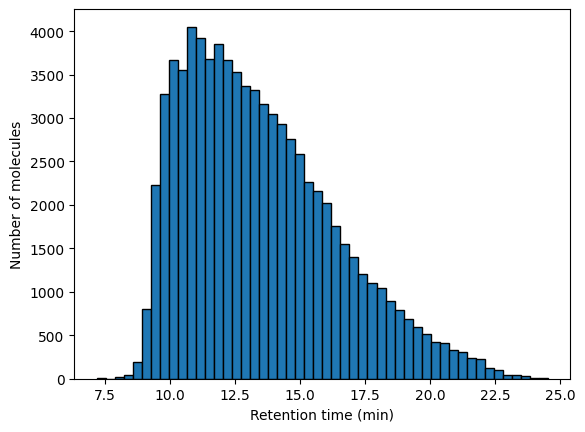

In [12]:
# Plot the distribution of the retention times
plt.hist(
    _data_adjusted_df['rt'] / 60, 
    bins=50, 
    edgecolor='black'
)
plt.xlabel('Retention time (min)')
plt.ylabel('Number of molecules')
plt.show()

# Generate Descriptors

In [13]:
_data_adjusted_smiles_df = MoleculeParser(_data_adjusted_df).inchi2smiles()

[15:01:44] Explicit valence for atom # 14 N, 4, is greater than permitted
[15:01:44] ERROR: Explicit valence for atom # 14 N, 4, is greater than permitted

[15:01:44] Explicit valence for atom # 16 N, 4, is greater than permitted
[15:01:44] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted

[15:01:44] Explicit valence for atom # 18 N, 4, is greater than permitted
[15:01:44] ERROR: Explicit valence for atom # 18 N, 4, is greater than permitted

[15:01:45] Explicit valence for atom # 17 N, 4, is greater than permitted
[15:01:45] ERROR: Explicit valence for atom # 17 N, 4, is greater than permitted



Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[15:01:45] ERROR: Explicit valence for atom # 15 N, 4, is greater than permitted

[15:01:45] Explicit valence for atom # 16 N, 4, is greater than permitted
[15:01:45] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted

[15:01:45] Explicit valence for atom # 23 N, 4, is greater than permitted
[15:01:45] ERROR: Explicit valence for atom # 23 N, 4, is greater than permitted

[15:01:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[15:01:45] ERROR: Explicit valence for atom # 15 N, 4, is greater than permitted

[15:01:45] Explicit valence for atom # 20 N, 4, is greater than permitted
[15:01:45] ERROR: Explicit valence for atom # 20 N, 4, is greater than permitted

[15:01:45] Explicit valence for atom # 15 N, 4, is greater than permitted
[15:01:45] ERROR: Explicit valence for atom # 15 N, 4, is greater than permitted

[15:01:45] Explicit valence for atom # 14 N, 4, is greater than 

Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:45] Explicit valence for atom # 17 N, 4, is greater than permitted
[15:01:45] ERROR: Explicit valence for atom # 17 N, 4, is greater than permitted

[15:01:45] Explicit valence for atom # 13 N, 4, is greater than permitted
[15:01:45] ERROR: Explicit valence for atom # 13 N, 4, is greater than permitted



Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:46] Explicit valence for atom # 26 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 26 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 16 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 25 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 25 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 11 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 11 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 16 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 18 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 18 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 16 N, 4, is greater than 

Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:46] Explicit valence for atom # 16 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 24 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 24 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 14 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 14 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 21 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 21 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 24 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 24 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 20 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 20 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 19 N, 4, is greater than 

Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:46] Explicit valence for atom # 16 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 14 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 14 N, 4, is greater than permitted

[15:01:46] Explicit valence for atom # 25 N, 4, is greater than permitted
[15:01:46] ERROR: Explicit valence for atom # 25 N, 4, is greater than permitted

[15:01:47] Explicit valence for atom # 25 N, 4, is greater than permitted
[15:01:47] ERROR: Explicit valence for atom # 25 N, 4, is greater than permitted

[15:01:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[15:01:47] ERROR: Explicit valence for atom # 10 N, 4, is greater than permitted

[15:01:47] Explicit valence for atom # 15 N, 4, is greater than permitted
[15:01:47] ERROR: Explicit valence for atom # 15 N, 4, is greater than permitted

[15:01:47] Explicit valence for atom # 20 N, 4, is greater than 

Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:47] Explicit valence for atom # 19 N, 4, is greater than permitted
[15:01:47] ERROR: Explicit valence for atom # 19 N, 4, is greater than permitted

[15:01:47] Explicit valence for atom # 26 N, 4, is greater than permitted
[15:01:47] ERROR: Explicit valence for atom # 26 N, 4, is greater than permitted



Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:48] Explicit valence for atom # 27 N, 4, is greater than permitted
[15:01:48] ERROR: Explicit valence for atom # 27 N, 4, is greater than permitted

[15:01:48] Explicit valence for atom # 13 N, 4, is greater than permitted
[15:01:48] ERROR: Explicit valence for atom # 13 N, 4, is greater than permitted



Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:48] Explicit valence for atom # 16 N, 4, is greater than permitted
[15:01:48] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted

[15:01:48] Explicit valence for atom # 23 N, 4, is greater than permitted
[15:01:48] ERROR: Explicit valence for atom # 23 N, 4, is greater than permitted

[15:01:48] Explicit valence for atom # 17 N, 4, is greater than permitted
[15:01:48] ERROR: Explicit valence for atom # 17 N, 4, is greater than permitted



Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:48] Explicit valence for atom # 24 N, 4, is greater than permitted
[15:01:48] ERROR: Explicit valence for atom # 24 N, 4, is greater than permitted

[15:01:49] Explicit valence for atom # 22 N, 4, is greater than permitted
[15:01:49] ERROR: Explicit valence for atom # 22 N, 4, is greater than permitted



Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:49] Explicit valence for atom # 18 N, 4, is greater than permitted
[15:01:49] ERROR: Explicit valence for atom # 18 N, 4, is greater than permitted

[15:01:49] Explicit valence for atom # 17 N, 4, is greater than permitted
[15:01:49] ERROR: Explicit valence for atom # 17 N, 4, is greater than permitted



Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:49] Explicit valence for atom # 17 N, 4, is greater than permitted
[15:01:49] ERROR: Explicit valence for atom # 17 N, 4, is greater than permitted



Error while parsing inchi to SMILES...


[15:01:50] Explicit valence for atom # 22 N, 4, is greater than permitted
[15:01:50] ERROR: Explicit valence for atom # 22 N, 4, is greater than permitted

[15:01:50] Explicit valence for atom # 18 N, 4, is greater than permitted
[15:01:50] ERROR: Explicit valence for atom # 18 N, 4, is greater than permitted

[15:01:50] Explicit valence for atom # 20 N, 4, is greater than permitted
[15:01:50] ERROR: Explicit valence for atom # 20 N, 4, is greater than permitted

[15:01:50] Explicit valence for atom # 21 N, 4, is greater than permitted
[15:01:50] ERROR: Explicit valence for atom # 21 N, 4, is greater than permitted

[15:01:50] Explicit valence for atom # 18 N, 4, is greater than permitted
[15:01:50] ERROR: Explicit valence for atom # 18 N, 4, is greater than permitted

[15:01:50] Explicit valence for atom # 19 N, 4, is greater than permitted
[15:01:50] ERROR: Explicit valence for atom # 19 N, 4, is greater than permitted



Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:50] Explicit valence for atom # 15 N, 4, is greater than permitted
[15:01:50] ERROR: Explicit valence for atom # 15 N, 4, is greater than permitted

[15:01:50] Explicit valence for atom # 19 N, 4, is greater than permitted
[15:01:50] ERROR: Explicit valence for atom # 19 N, 4, is greater than permitted

[15:01:50] Explicit valence for atom # 22 N, 4, is greater than permitted
[15:01:50] ERROR: Explicit valence for atom # 22 N, 4, is greater than permitted

[15:01:50] Explicit valence for atom # 18 N, 4, is greater than permitted
[15:01:50] ERROR: Explicit valence for atom # 18 N, 4, is greater than permitted

[15:01:50] Explicit valence for atom # 24 N, 4, is greater than permitted
[15:01:50] ERROR: Explicit valence for atom # 24 N, 4, is greater than permitted

[15:01:50] Explicit valence for atom # 19 N, 4, is greater than permitted
[15:01:50] ERROR: Explicit valence for atom # 19 N, 4, is greater than permitted



Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:51] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number)

[15:01:55] Explicit valence for atom # 22 N, 4, is greater than permitted
[15:01:55] ERROR: Explicit valence for atom # 22 N, 4, is greater than permitted



Error while parsing inchi to SMILES...


[15:01:56] Explicit valence for atom # 25 N, 4, is greater than permitted
[15:01:56] ERROR: Explicit valence for atom # 25 N, 4, is greater than permitted

[15:01:56] Explicit valence for atom # 21 N, 4, is greater than permitted
[15:01:56] ERROR: Explicit valence for atom # 21 N, 4, is greater than permitted

[15:01:56] Explicit valence for atom # 21 N, 4, is greater than permitted
[15:01:56] ERROR: Explicit valence for atom # 21 N, 4, is greater than permitted

[15:01:56] Explicit valence for atom # 23 N, 4, is greater than permitted
[15:01:56] ERROR: Explicit valence for atom # 23 N, 4, is greater than permitted



Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:56] Explicit valence for atom # 22 N, 4, is greater than permitted
[15:01:56] ERROR: Explicit valence for atom # 22 N, 4, is greater than permitted

[15:01:56] Explicit valence for atom # 22 N, 4, is greater than permitted
[15:01:56] ERROR: Explicit valence for atom # 22 N, 4, is greater than permitted

[15:01:56] Explicit valence for atom # 22 N, 4, is greater than permitted
[15:01:56] ERROR: Explicit valence for atom # 22 N, 4, is greater than permitted

[15:01:56] Explicit valence for atom # 18 N, 4, is greater than permitted
[15:01:56] ERROR: Explicit valence for atom # 18 N, 4, is greater than permitted



Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...
Error while parsing inchi to SMILES...


[15:01:58] Explicit valence for atom # 24 N, 4, is greater than permitted
[15:01:58] ERROR: Explicit valence for atom # 24 N, 4, is greater than permitted



Error while parsing inchi to SMILES...


[15:02:01] Explicit valence for atom # 16 N, 4, is greater than permitted
[15:02:01] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted



Error while parsing inchi to SMILES...


[15:02:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[15:02:03] ERROR: Explicit valence for atom # 25 N, 4, is greater than permitted



Error while parsing inchi to SMILES...


[15:02:06] Explicit valence for atom # 19 N, 4, is greater than permitted
[15:02:06] ERROR: Explicit valence for atom # 19 N, 4, is greater than permitted



Error while parsing inchi to SMILES...


[15:02:07] Explicit valence for atom # 16 N, 4, is greater than permitted
[15:02:07] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted



Error while parsing inchi to SMILES...


[15:02:08] Explicit valence for atom # 21 N, 4, is greater than permitted
[15:02:08] ERROR: Explicit valence for atom # 21 N, 4, is greater than permitted



Error while parsing inchi to SMILES...


[15:02:27] Explicit valence for atom # 16 N, 4, is greater than permitted
[15:02:27] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted



Error while parsing inchi to SMILES...


In [14]:
_data_adjusted_smiles_df.to_csv(
    SMRT_DATASET_SMILES, 
    index=False
)

In [15]:
_data_adjusted_smiles_df.head()

,smiles,rt
0,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,687.8
1,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1OC,590.7
2,Oc1cccc2c(O)nccc12,583.6
3,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1,579.0
4,CC(C)(C)NC[C@H](O)COc1cccc2nc(O)[nH]c12,603.1


# Create Dataset


In [16]:
# Build vocabulary of SMILES characters
_vocabulary, _inverse_vocabulary = MoleculeEncoder.build(_data_adjusted_smiles_df, file_path=None)

In [17]:
print(_vocabulary)

{'<PAD>': 0, '<UNK>': 1, '[CH]': 2, '1': 3, '[N@]': 4, '9': 5, '[H]': 6, 'n': 7, '[O-]': 8, '[S@]': 9, '[N+]': 10, 'c': 11, 'o': 12, 's': 13, '8': 14, '(': 15, '[C@@]': 16, 'F': 17, '[Si]': 18, '5': 19, '=': 20, '7': 21, '-': 22, '[nH]': 23, 'Br': 24, '[S+]': 25, '2': 26, '[P@@]': 27, '4': 28, '#': 29, '3': 30, 'O': 31, '[C@@H]': 32, '\\': 33, '[S@@]': 34, '/': 35, '[NH+]': 36, '[P@]': 37, '[N-]': 38, '[C@]': 39, ')': 40, '[N@+]': 41, 'S': 42, 'I': 43, '[Si@]': 44, '6': 45, '[N@@]': 46, 'P': 47, 'N': 48, 'Cl': 49, '[C-]': 50, '[C@H]': 51, '[n+]': 52, 'C': 53}


In [18]:
# Encode SMILES to integers
_encoded_smiles_array = MoleculeEncoder.encode(_data_adjusted_smiles_df, _vocabulary, 90, MoleculeEncodingType.OneHot)

In [19]:
_encoded_smiles_array.shape

(77895, 90, 54)

In [20]:
# Check if the process is reversible
_random_compound_idx: int = random.randint(0, _encoded_smiles_array.shape[0])
_random_smiles_encoded: str = _encoded_smiles_array[_random_compound_idx, :, :]
_random_smiles_decoded: str = MoleculeEncoder.decode(_random_smiles_encoded, _inverse_vocabulary, MoleculeEncodingType.OneHot)

In [21]:
_random_smiles_encoded

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [22]:
_random_smiles_decoded == _data_adjusted_smiles_df.loc[_random_compound_idx, "smiles"]

True

# Save the Dataset

In [23]:
with open(SMRT_DATASET_ENCODED_SMILES, "wb") as f:
    pickle.dump(_encoded_smiles_array, f)